In [196]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

In [197]:
import sys
sys.path.append("..")
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
from example_systems import generate_mackey_glass_system

mg_system_gt = generate_mackey_glass_system()

In [199]:
from helpers import vec

timesteps = np.arange(0.0, 3, step=mg_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 1, 1))
controls = np.zeros((T, 1, 1))
measurements = np.zeros((T, 1, 1))

# initial position and velocity
states_gt[0] = vec(
    0.1              # P
)

# cart acceleration schedule
t = np.min(np.argwhere(timesteps > 1.0))
controls = timesteps

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = mg_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = mg_system_gt.query_measurement_model(x_next)
    measurements[t] = z


100%|██████████| 299/299 [00:00<00:00, 666.18it/s]


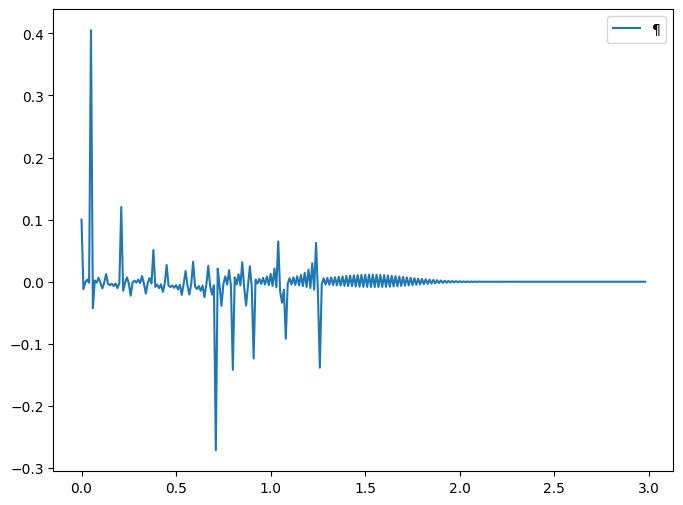

In [200]:
t_max = np.max(np.argwhere(~np.isnan(states_gt[:,0,0])))

if t_max < T-1:
    print("WARNING: System diverges at around t =", t_max)
    t_max -= 10

P_gt = states_gt[:t_max,0,0]


fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(timesteps[:t_max], cart_gt, label="cart")
# ax.plot(timesteps[:t_max], cart_vel_gt, label="cart_vel")
ax.plot(timesteps[:t_max], P_gt, label=r"$\P$")
ax.legend(ncol=2)

In [201]:
# Test all filters on same system model approximation
subsample = 10            # filters run at a fraction of sampling rate of the simulation
timesteps_sub = timesteps[::subsample]
states_gt_sub = states_gt[::subsample]
measurements_sub = measurements[::subsample]
controls_sub = controls[::subsample]
T_sub = len(timesteps_sub)

mg_system_approx = generate_mackey_glass_system(dt=mg_system_gt.delta_t * subsample)

In [202]:
# Test all filters with the same initial belief
initial_covariance = np.diag([1e-3])
initial_mean = np.random.multivariate_normal(states_gt[0,:,0], initial_covariance).reshape(-1, 1)

initial_state_estimate = (initial_mean, initial_covariance)
initial_state_estimate

(array([[0.09796882]]), array([[0.001]]))

In [203]:
def plot_filter_results(means, filter_name): # Needs to be updated for this system
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(3, 0.5), constrained_layout=True)
    fig.suptitle(f"Filtering Results: {filter_name}")

    ax1.set_xlabel("time")
    ax1.plot(timesteps_sub, states_gt_sub[:,0,0], label=r"$x$", color="tab:blue")
    ax1.plot(timesteps_sub, states_gt_sub[:,1,0], label=r"$\theta_1$", color="tab:orange")
    ax1.plot(timesteps_sub, states_gt_sub[:,2,0], label=r"$\theta_2$", color="tab:red")
    ax1.plot(timesteps_sub, means[:,0,0], label=rf"$x$ ({filter_name})", color="tab:blue", linestyle="--")
    ax1.plot(timesteps_sub, means[:,1,0], label=rf"$\theta_1$ ({filter_name})", color="tab:orange", linestyle="--")
    ax1.plot(timesteps_sub, means[:,2,0], label=rf"$\theta_2$ ({filter_name})", color="tab:red", linestyle="--")

    for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
        ax1.axhline(y, linestyle=":", color="gray")

    ax1.legend(ncol=2)

    ax2.set_xlabel("time")
    ax2.plot(timesteps_sub, states_gt_sub[:,3,0], label=r"$\dot x$", color="tab:blue")
    ax2.plot(timesteps_sub, states_gt_sub[:,4,0], label=r"$\dot\theta_1$", color="tab:orange")
    ax2.plot(timesteps_sub, states_gt_sub[:,5,0], label=r"$\dot\theta_2$", color="tab:red")
    ax2.plot(timesteps_sub, means[:,3,0], label=rf"$\dot x$ ({filter_name})", color="tab:blue", linestyle="--")
    ax2.plot(timesteps_sub, means[:,4,0], label=rf"$\dot\theta_1$ ({filter_name})", color="tab:orange", linestyle="--")
    ax2.plot(timesteps_sub, means[:,5,0], label=rf"$\dot\theta_2$ ({filter_name})", color="tab:red", linestyle="--")

    for y in np.arange(-2*np.pi, 3*np.pi, step=np.pi/2):
        ax2.axhline(y, linestyle=":", color="gray")

    ax2.legend(ncol=2)

In [204]:
# Run the EKF

from filters import ExtendedKalmanFilter

mg_EKF = ExtendedKalmanFilter(mg_system_approx)

# initial state belief
mg_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T_sub, 6, 1))
covariances_EKF = np.zeros((T_sub, 1, 1))

means_EKF[0] = mg_EKF.mean
covariances_EKF[0] = mg_EKF.covariance

for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_EKF.predict_step(u)
    mg_EKF.update_step(z)

    means_EKF[t] = mg_EKF.mean
    covariances_EKF[t] = mg_EKF.covariance

# Plot results
#plot_filter_results(means_EKF, "EKF")

ImportError: cannot import name 'HistogramDistribution' from partially initialized module 'probability.distributions' (most likely due to a circular import) (c:\Users\Ian Krause\Documents\GitHub\UKF-Variants\src\testing/..\probability\distributions.py)

100%|██████████| 2499/2499 [00:05<00:00, 424.30it/s]


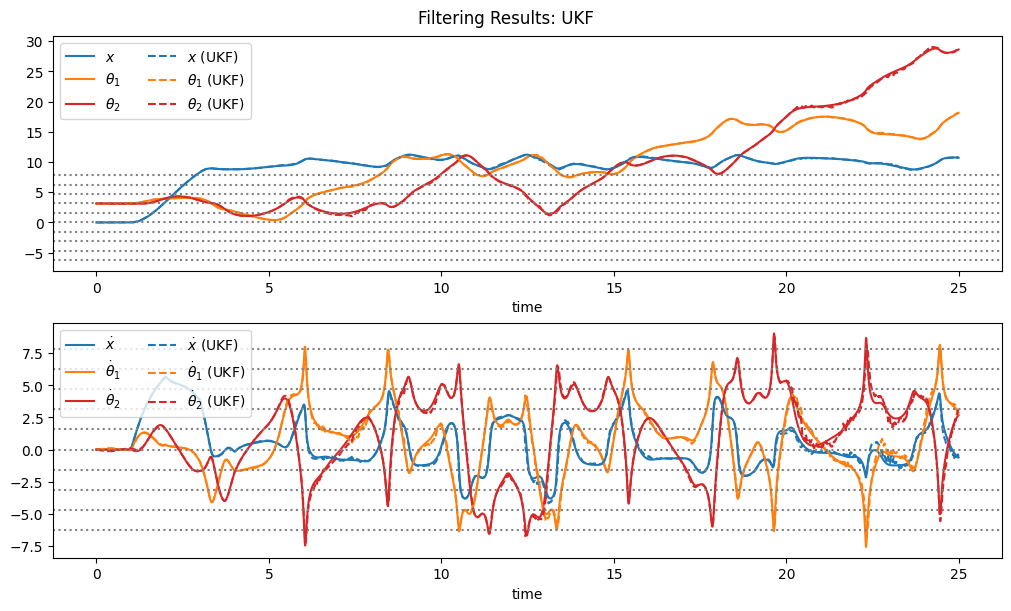

In [ ]:
# Run the UKF

from filters import UnscentedKalmanFilter
mg_UKF = UnscentedKalmanFilter(mg_system_approx)

# initial state belief
mg_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T_sub, 1, 1))
covariances_UKF = np.zeros((T_sub, 1, 1))

means_UKF[0] = mg_UKF.mean
covariances_UKF[0] = mg_UKF.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF.predict_step(u)
    mg_UKF.update_step(z)

    means_UKF[t] = mg_UKF.mean
    covariances_UKF[t] = mg_UKF.covariance


# Plot results
plot_filter_results(means_UKF, "UKF")

100%|██████████| 2499/2499 [00:10<00:00, 234.23it/s]


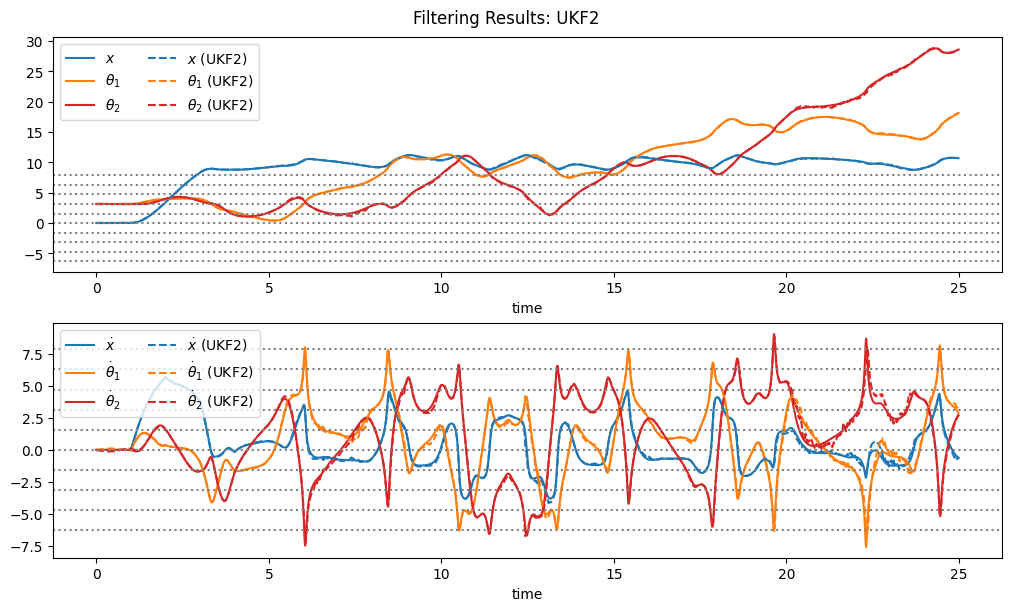

In [ ]:
# Run the UKF Variant

from sigma_points import MultiShellSigmaPointSelector

mg_UKF2 = UnscentedKalmanFilter(
    mg_system_approx,
    sigma_point_selector=MultiShellSigmaPointSelector([0.1, 0.5])
)

# initial state belief
mg_UKF2.initialize(*initial_state_estimate)

means_UKF2 = np.zeros((T_sub, 6, 1))
covariances_UKF2 = np.zeros((T_sub, 6, 6))

means_UKF2[0] = mg_UKF2.mean
covariances_UKF2[0] = mg_UKF2.covariance


for t in tqdm(range(1, T_sub)):
    u = controls_sub[t]
    z = measurements_sub[t]

    mg_UKF2.predict_step(u)
    mg_UKF2.update_step(z)

    means_UKF2[t] = mg_UKF2.mean
    covariances_UKF2[t] = mg_UKF2.covariance


# Plot results
plot_filter_results(means_UKF2, "UKF2")

In [ ]:
# Error Analysis

errors_EKF = means_EKF - states_gt_sub
errors_UKF = means_UKF - states_gt_sub
errors_UKF2 = means_UKF2 - states_gt_sub

print("EKF Error: ", np.mean(np.linalg.norm(errors_EKF, axis=1)))
print("UKF Error: ", np.mean(np.linalg.norm(errors_UKF, axis=1)))
print("UKF2 Error:", np.mean(np.linalg.norm(errors_UKF2, axis=1)))

EKF Error:  6.06792072447799
UKF Error:  0.2812465004491158
UKF2 Error: 0.25947067790612793
